In [1]:
%pip install pandas nltk pyvi gensim tensorflow-hub matplotlib
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install tensorflow
%pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=0c7006d0e96822e8b8a1f9c79dcfbefb33110f2b5fd67587b797e50444d2a6bc
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import torch
import tensorflow as tf

if torch.cuda.is_available():
    print("Torch - GPU is available.")
else:
    print("Torch - GPU is not available.")

if len(tf.config.list_physical_devices('GPU')) != 0:
    print("Tensorflow - GPU is available.")
else:
    print("Tensorflow - GPU is not available.")

Torch - GPU is available.
Tensorflow - GPU is available.


In [66]:
env = "colab".lower()
we = "w2v".lower()
architecture = "cnn_lstm".lower()

# 1. Loading & Preprocessing data

In [4]:
import re
import pandas as pd
import numpy as np
from pyvi import ViTokenizer, ViPosTagger
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
if env == "local":
    data_path = "./data"
    we_path = "./embeddings"
    result_path = "./results/"
elif env == "colab":
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/data"
    we_path = "/content/drive/MyDrive/Colab Notebooks/NLP/embeddings"
    result_path = "/content/drive/MyDrive/Colab Notebooks/NLP/results"

Mounted at /content/drive


In [6]:
# Load train and test data from csv files
data_train = pd.read_csv(f"{data_path}/vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
train_labels = data_train.iloc[:, 0].values
train_texts = data_train.iloc[:, 1].values
print("Training data\n", data_train.head(5))

data_test = pd.read_csv(f"{data_path}/vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']
test_labels = data_test.iloc[:, 0].values
test_texts = data_test.iloc[:, 1].values
print("Testing data\n", data_test.head(5))

Training data
    Class                                               Data
0     -1  Mình đã dùng anywhere thế hệ đầu, quả là đầy t...
1     -1  Quan tâm nhất là độ trễ có cao không, dùng thi...
2     -1  dag xài con cùi bắp 98k....pin trâu, mỗi tội đ...
3     -1  logitech chắc hàng phải tiền triệu trở lên dùn...
4     -1  Đang xài con m175 cùi mía , nhà xài nhiều chuộ...
Testing data
    Class                                               Data
0     -1  Nói thiệt là mình thì thì chuột nào mình cũng ...
1     -1  Đang dùng mx1. Cũng ngon nhưng chưa đầy năm mà...
2     -1  Chưa thấy đc điểm thuyết phục để mua, nhất là ...
3     -1  Những phần xem báo tra cứu bản đồ, dịch vụ.. d...
4     -1  ĐÚNG LÀ MUA Ở VIỆT NAM KHÔNG ỨNG DỤNG ĐƯỢC GÌ ...


## 1.1. Encoding labels

In [7]:
# -1 = Negative = [1,0,0]
#  0 = Neutral   = [0,1,0]
#  1 = Positive = [0,0,1]
def encoding_labels(labels):
    encoded_labels = []
    for label in labels:
        if label == -1:
            encoded_labels += [[1, 0, 0]]
        elif label == 0:
            encoded_labels += [[0, 1, 0]]
        else:
            encoded_labels += [[0 ,0, 1]]
    return np.array(encoded_labels)

In [8]:
encoded_labels_train = encoding_labels(train_labels)
for label in encoded_labels_train[:5]:
    print(f"- {label}")

- [1 0 0]
- [1 0 0]
- [1 0 0]
- [1 0 0]
- [1 0 0]


## 1.2. Preprocessing texts

In [9]:
# https://blog.luyencode.net/phan-loai-van-ban-tieng-viet/
# Cleaning text
def remove_html(text):
    pattern = r'<[^>]*>'
    non_html_text = re.sub(pattern, '', text)
    return non_html_text

def standardize_unicode(text):
    def load_standardized_unicode_dict():
        dic = {}
        char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
        charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
        for i in range(len(char1252)):
            dic[char1252[i]] = charutf8[i]
        return dic

    standardized_unicode_dict = load_standardized_unicode_dict()
    pattern = r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    standardize_unicode_text = re.sub(pattern, lambda x: standardized_unicode_dict[x.group()], text)
    return standardize_unicode_text

def normalize_tone(text):
    def load_normalized_tone_dict():
        dic = {}
        normalized = 'oà|Oà|OÀ|oá|Oá|OÁ|oả|Oả|OẢ|oã|Oã|OÃ|oạ|Oạ|OẠ|oè|Oè|OÈ|oé|Oé|OÉ|oẻ|Oẻ|OẺ|oẽ|Oẽ|OẼ|oẹ|Oẹ|OẸ|uỳ|Uỳ|UỲ|uý|Uý|UÝ|uỷ|Uỷ|UỶ|uỹ|Uỹ|UỸ|uỵ|Uỵ|UỴ'.split('|')
        non_normalized = 'òa|Òa|ÒA|óa|Óa|ÓA|ỏa|Ỏa|ỎA|õa|Õa|ÕA|ọa|Ọa|ỌA|òe|Òe|ÒE|óe|Óe|ÓE|ỏe|Ỏe|ỎE|õe|Õe|ÕE|ọe|Ọe|ỌE|ùy|Ùy|ÙY|úy|Úy|ÚY|ủy|Ủy|ỦY|ũy|Ũy|ŨY|ụy|Ụy|ỤY'.split('|')
        for i in range(len(non_normalized)):
            dic[non_normalized[i]] = normalized[i]
        return dic

    normalized_tone_dict = load_normalized_tone_dict()
    pattern = r'òa|Òa|ÒA|óa|Óa|ÓA|ỏa|Ỏa|ỎA|õa|Õa|ÕA|ọa|Ọa|ỌA|òe|Òe|ÒE|óe|Óe|ÓE|ỏe|Ỏe|ỎE|õe|Õe|ÕE|ọe|Ọe|ỌE|ùy|Ùy|ÙY|úy|Úy|ÚY|ủy|Ủy|ỦY|ũy|Ũy|ŨY|ụy|Ụy|ỤY'
    normalized_tone_text = re.sub(pattern, lambda x: normalized_tone_dict[x.group()], text)
    return normalized_tone_text

def tokenize_texts(text):
    tokenized_text = ViTokenizer.tokenize(text)
    return tokenized_text.split()

def remove_special_chars(text):
    # # Remove all special characters
    pattern = r'[^a-zA-Z0-9\w\sáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ_]'
    processed_text = re.sub(pattern, ' ', text)
    # Remove all numeric characters
    pattern = r'\d+'
    processed_text = re.sub(pattern, ' ', processed_text)
    # Remove 2 or more spaces
    pattern = r'\s+'
    processed_text = re.sub(pattern, ' ', processed_text)
    return processed_text

def cleaning_pipeline(texts):
    results = []
    for text in texts:
        text = text.lower()
        non_html_text  = remove_html(text)
        standardize_unicode_text = standardize_unicode(non_html_text)
        normalized_tone_text = normalize_tone(standardize_unicode_text)
        processed_text = remove_special_chars(normalized_tone_text)
        tokenized_text = tokenize_texts(processed_text)
        results += [tokenized_text]
    return results

# List frequency of words
def word_frequency(texts):
    words = [word for text in texts for word in text]
    word_counts = Counter(words)
    word_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Frequency'])
    word_df = word_df.sort_values(by='Frequency', ascending=False)
    return word_df

# Add the most frequent words to stopwords list
def append_stopwords_list(texts, stopwords, threshhold=800):
    new_stopwords = stopwords.copy()
    word_df = word_frequency(texts)
    most_frequent_words = word_df[word_df['Frequency'] > threshhold]
    for word in most_frequent_words['Word'].values:
        if word not in new_stopwords:
            new_stopwords += [word]
    return new_stopwords

# Remove stopwords from texts
def remove_stopwords(texts, stopwords):
    filtered_texts = []
    for text in texts:
        filtered_words = [word for word in text if word not in stopwords]
        filtered_text = ' '.join(filtered_words)
        filtered_texts += [filtered_text]
    return filtered_texts

def pad_texts(sentences, max_vocab_size, max_sequence_len, tokenizer=None):
    if tokenizer == None:
        tokenizer = Tokenizer(num_words=max_vocab_size, lower=True, char_level=False)
        tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    input_data = pad_sequences(sequences, maxlen=max_sequence_len)
    return input_data, tokenizer.word_index, tokenizer

def preprocessing_pipeline(texts, max_vocab_size, max_sequence_len, stopwords_vi=None, tokenizer=None):
    clean_texts = cleaning_pipeline(texts)
    if stopwords_vi:
      filtered_texts = remove_stopwords(clean_texts, stopwords_vi)
    else:
      filtered_texts = clean_texts
    padded_texts, word_index, tokenizer = pad_texts(filtered_texts, max_vocab_size, max_sequence_len, tokenizer)
    return padded_texts, word_index, tokenizer

In [10]:
clean_texts_train = cleaning_pipeline(train_texts)
for text in clean_texts_train[:5]:
    print(f"- {text}")

- ['mình', 'đã', 'dùng', 'anywhere', 'thế_hệ', 'đầu', 'quả', 'là', 'đầy', 'thất_vọng', 'hiện_tại', 'đang', 'vứt', 'xó', 'giá', 'thì', 'đắt', 'ngốn', 'pin', 'như', 'ăn_gỏi', 'nặng']
- ['quan_tâm', 'nhất', 'là', 'độ', 'trễ', 'có', 'cao', 'không', 'dùng', 'thi_thoảng', 'nó', 'cứ', 'trễ', 'bực_mình', 'đấy', 'mới', 'chỉ', 'là', 'dùng', 'văn_phòng', 'chứ', 'game', 'thì', 'chắc', 'là', 'ném', 'đi', 'từ', 'lâu', 'không', 'biết', 'con', 'này', 'có', 'độ', 'trễ', 'không', 'nhỉ', 'dùng', 'nhiều', 'loại', 'nhưng', 'vẫn', 'kết', 'nhất', 'con', 'chuột', 'sứ', 'mitsumi', 'gọn', 'bấm', 'nảy', 'tốt']
- ['dag', 'xài', 'con', 'cùi', 'bắp', 'k', 'pin', 'trâu', 'mỗi', 'tội', 'đánh', 'liên_minh', 'ức_chế', 'đập', 'hết', 'con']
- ['logitech', 'chắc', 'hàng', 'phải', 'tiền', 'triệu', 'trở', 'lên', 'dùng', 'mới', 'thích', 'chứ', 'em', 'dùng', 'con', 'có', 'k', 'thấy', 'được', 'vài', 'bữa', 'là', 'hư', 'chuyển', 'sang', 'eblue', 'dùng', 'được', 'hơn', 'năm', 'chưa', 'thấy', 'hỏng']
- ['đang', 'xài', 'con', 'm',

In [11]:
# # Import a Vietnamese stopwords list
# # https://github.com/stopwords-iso/stopwords-vi/blob/master/stopwords-vi.txt
# with open(f"{data_path}/stopwords_vi.txt", 'r', encoding='utf-8') as file:
#     stopwords_vi = sorted([line.strip() for line in file])
#     print(f"Vietnamese stopwords ({len(stopwords_vi)} elements):\n{stopwords_vi}\n")
#     # stopwords_vi = sorted(append_stopwords_list(cleaning_pipeline(train_texts) + cleaning_pipeline(test_texts), stopwords_vi))
#     # print(f"Appended Vietnamese stopwords ({len(stopwords_vi)} elements):\n{stopwords_vi}\n")

# clean_texts_train = remove_stopwords(clean_texts_train, stopwords_vi)
# for text in clean_texts_train[:5]:
#     print(f"- {text}")

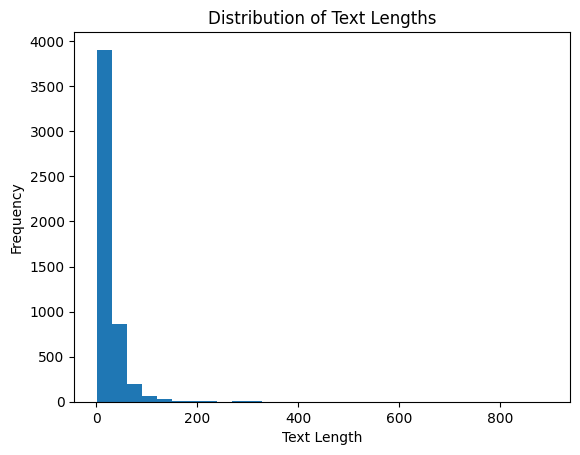

In [12]:
import matplotlib.pyplot as plt

# Assuming 'sequences' is the list of sequences obtained from tokenizing the text
text_lengths = [len(seq) for seq in clean_texts_train if len(seq) < 1000]

plt.hist(text_lengths, bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 2. Computing Word Embedding

In [67]:
from gensim.models.keyedvectors import KeyedVectors
from sentence_transformers import SentenceTransformer

In [68]:
if we == "w2v":
  MAX_SEQUENCE_LENGTH = 256 # max number of words in an input sentence
  EMBEDDING_DIM = 400       # how big is each embedding vector
elif we == "bert":
  MAX_SEQUENCE_LENGTH = 256 # max number of words in an input sentence
  EMBEDDING_DIM = 768       # how big is each embedding vector
MAX_VOCAB_SIZE = 10000      # how many unique words to use (i.e num rows in embedding vector)

X_input, word_index, tokenizer = pad_texts(clean_texts_train, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH)
y_input = encoded_labels_train

print(f"Shape of X input tensor: {X_input.shape}")
print(f"Shape of y input tensor: {y_input.shape}")

vocabulary_size = min(len(word_index) + 1, MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

if we == "w2v":
  word_vectors = KeyedVectors.load_word2vec_format(fname=f'{we_path}/vi-model-CBOW.bin', binary=True)
  for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
      try:
          embedding_vector = word_vectors[word]
          embedding_matrix[i] = embedding_vector
      except KeyError:
          embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)
elif we == "bert":
  # https://huggingface.co/keepitreal/vietnamese-sbert
    we_model = SentenceTransformer('keepitreal/vietnamese-sbert', device='cuda')
    word_vectors = we_model.encode(list(word_index.keys()))
    for i in range(len(word_index)):
      if i < MAX_VOCAB_SIZE:
        embedding_matrix[i] = word_vectors[i]

print(f"Shape of an input embedding: {embedding_matrix[0].shape}\n")

Shape of X input tensor: (5100, 256)
Shape of y input tensor: (5100, 3)
Shape of an input embedding: (768,)



# 3. Building the model

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Bidirectional, Dense
from tensorflow.keras.layers import Reshape, concatenate, Concatenate, Flatten, Activation, BatchNormalization, Attention, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, save_model
from sklearn.model_selection import train_test_split

## 3.1. CNN

In [28]:
def cnn_model(seq_len, embed_dim):
    # CNN hyperparameters
    SEQUENCE_LENGTH = seq_len
    EMBEDDING_DIM = embed_dim
    FILTER_SIZES = [3, 4, 5]
    NUM_FILTERS = 100
    REGULIZERS_LAMBDA = 0.01
    DROP_RATE = 0.5

    # Optimizer hyperparameters
    LEARNING_RATE = 0.001
    BETA_1 = 0.9
    BETA_2 = 0.999
    EPSILON = 1e-08

    # Define the CNN model

    input_layer = Input(shape=(SEQUENCE_LENGTH,))

    embedding_layer = Embedding(input_dim=vocabulary_size,
                                output_dim=EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                trainable=True)(input_layer)

    conv_layer_0 = Conv1D(NUM_FILTERS,
                          FILTER_SIZES[0],
                          activation='relu',
                          kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(embedding_layer)
    conv_layer_1 = Conv1D(NUM_FILTERS,
                          FILTER_SIZES[1],
                          activation='relu',
                          kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(embedding_layer)
    conv_layer_2 = Conv1D(NUM_FILTERS,
                          FILTER_SIZES[2],
                          activation='relu',
                          kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(embedding_layer)

    maxpool_layer_0 = MaxPooling1D(SEQUENCE_LENGTH - FILTER_SIZES[0] + 1, strides=1)(conv_layer_0)
    maxpool_layer_1 = MaxPooling1D(SEQUENCE_LENGTH - FILTER_SIZES[1] + 1, strides=1)(conv_layer_1)
    maxpool_layer_2 = MaxPooling1D(SEQUENCE_LENGTH - FILTER_SIZES[2] + 1, strides=1)(conv_layer_2)

    merged_tensor = concatenate([maxpool_layer_0, maxpool_layer_1, maxpool_layer_2], axis=1)

    # Attention layer
    attention = Attention()([merged_tensor, merged_tensor]) # self-attention

    # Attention output is concatenated with the LSTM output
    attended_output = Concatenate(axis=-1)([merged_tensor, attention])

    flatten = Flatten()(attended_output)

    dropout = Dropout(DROP_RATE)(flatten)

    fc_layer = Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(dropout)

    output_layer = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(fc_layer)

    model = Model(input_layer, output_layer)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON),
                  metrics=['accuracy'])

    model._name = f"cnn_{we}"
    print(model.summary())
    return model

## 3.2. LSTM

In [17]:
def lstm_model(seq_len, embed_dim):
    # LSTM hyperparameters
    SEQUENCE_LENGTH = seq_len
    EMBEDDING_DIM = embed_dim
    REGULIZERS_LAMBDA = 0.01
    DROP_RATE = 0.5

    # Optimizer hyperparameters
    LEARNING_RATE = 0.001
    BETA_1 = 0.9
    BETA_2 = 0.999
    EPSILON = 1e-08

    # Define the LSTM model
    input_layer = Input(shape=(SEQUENCE_LENGTH,))

    embedding_layer = Embedding(input_dim=vocabulary_size,
                                output_dim=EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                trainable=True)(input_layer)

    # lstm_layer_0 = Bidirectional(LSTM(units=256, return_sequences=True))(embedding_layer)
    # lstm_layer_1 = Bidirectional(LSTM(units=128, return_sequences=True))(lstm_layer_0)
    # lstm_layer_2 = Bidirectional(LSTM(units=64, return_sequences=False))(lstm_layer_1)

    lstm_layer_2 = LSTM(units=128, return_sequences=False)(embedding_layer)

    # Attention layer
    attention = Attention()([lstm_layer_2, lstm_layer_2]) # self-attention

    # Attention output is concatenated with the LSTM output
    attended_output = Concatenate(axis=-1)([lstm_layer_2, attention])

    dropout = Dropout(DROP_RATE)(attended_output)

    fc_layer = Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(dropout)

    output_layer = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(fc_layer)

    model = Model(input_layer, output_layer)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON),
                  metrics=['accuracy'])

    model._name = f"lstm_{we}"
    print(model.summary())
    return model

## 3.3. CNN_LSTM

In [18]:
def cnn_lstm_model(seq_len, embed_dim):
    # CNN_LSTM hyperparameters
    SEQUENCE_LENGTH = seq_len
    EMBEDDING_DIM = embed_dim
    FILTER_SIZES = [3, 4, 5]
    NUM_FILTERS = 100
    REGULIZERS_LAMBDA = 0.01
    DROP_RATE = 0.5

    # Optimizer hyperparameters
    LEARNING_RATE = 0.001
    BETA_1 = 0.9
    BETA_2 = 0.999
    EPSILON = 1e-08

    # Define the CNN model
    input_layer = Input(shape=(SEQUENCE_LENGTH,))

    embedding_layer = Embedding(input_dim=vocabulary_size,
                                output_dim=EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                trainable=True)(input_layer)

    reshape = Reshape((SEQUENCE_LENGTH, EMBEDDING_DIM))(embedding_layer)

    conv_layer_0 = Conv1D(NUM_FILTERS,
                          FILTER_SIZES[0],
                          activation='relu',
                          kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(reshape)
    conv_layer_1 = Conv1D(NUM_FILTERS,
                          FILTER_SIZES[1],
                          activation='relu',
                          kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(reshape)
    conv_layer_2 = Conv1D(NUM_FILTERS,
                          FILTER_SIZES[2],
                          activation='relu',
                          kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(reshape)

    maxpool_layer_0 = MaxPooling1D(SEQUENCE_LENGTH - FILTER_SIZES[0] + 1, strides=1)(conv_layer_0)
    maxpool_layer_1 = MaxPooling1D(SEQUENCE_LENGTH - FILTER_SIZES[1] + 1, strides=1)(conv_layer_1)
    maxpool_layer_2 = MaxPooling1D(SEQUENCE_LENGTH - FILTER_SIZES[2] + 1, strides=1)(conv_layer_2)

    merged_tensor = concatenate([maxpool_layer_0, maxpool_layer_1, maxpool_layer_2], axis=1)

    # lstm_layer_2 = Bidirectional(LSTM(units=128, return_sequences=False))(merged_tensor)

    lstm_layer_2 = LSTM(units=128, return_sequences=False)(merged_tensor)

    # Attention layer
    attention = Attention()([lstm_layer_2, lstm_layer_2]) # self-attention

    # Attention output is concatenated with the LSTM output
    attended_output = Concatenate(axis=-1)([lstm_layer_2, attention])

    dropout = Dropout(DROP_RATE)(attended_output)

    fc_layer = Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(dropout)

    output_layer = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(REGULIZERS_LAMBDA))(fc_layer)

    model = Model(input_layer, output_layer)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON),
                  metrics=['accuracy'])

    model._name = f"cnn_lstm_{we}"
    print(model.summary())
    return model

# 4. Training the model

In [54]:
if architecture == "cnn":
    model = cnn_model(X_input.shape[1], embedding_matrix[0].shape[0])
if architecture == "lstm":
    model = lstm_model(X_input.shape[1], embedding_matrix[0].shape[0])
if architecture == "cnn_lstm":
    model = cnn_lstm_model(X_input.shape[1], embedding_matrix[0].shape[0])

Model: "cnn_lstm_w2v"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, 256, 400)             3160400   ['input_16[0][0]']            
                                                                                                  
 reshape_8 (Reshape)         (None, 256, 400)             0         ['embedding_15[0][0]']        
                                                                                                  
 conv1d_36 (Conv1D)          (None, 254, 100)             120100    ['reshape_8[0][0]']           
                                                                                       

In [ ]:
# Early stopping hyperparameters
MIN_DELTA = 0.01
PATIENCE = 10

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=MIN_DELTA,
                               patience=PATIENCE,
                               restore_best_weights=True,
                               verbose=1)
callbacks_list = [early_stopping]

# Training hyperparameters
EPOCH = 30
BATCH_SIZE = 258

# Set the random seed for reproducibility
np.random.seed(42)
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_input, y_input, test_size=0.2, shuffle=True, random_state=42)

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list)
history = history.history

In [ ]:
pd.DataFrame(history).to_csv(f'{result_path}/{architecture}_{we}_log.csv', encoding='utf-8')
save_model(model, f'{result_path}/{architecture}_{we}_checkpoint.h5')
print(f"Model '{architecture}_{we}' saved.")

# 4. Evaluating model

In [75]:
architecture = "cnn_lstm"
we = "bert"
model = load_model(f'{result_path}/{architecture}_{we}_checkpoint.h5')
history = pd.read_csv(f'{result_path}/{architecture}_{we}_log.csv', index_col=0)
print(f"Model '{architecture}_{we}' loaded.")

Model 'cnn_lstm_bert' loaded.


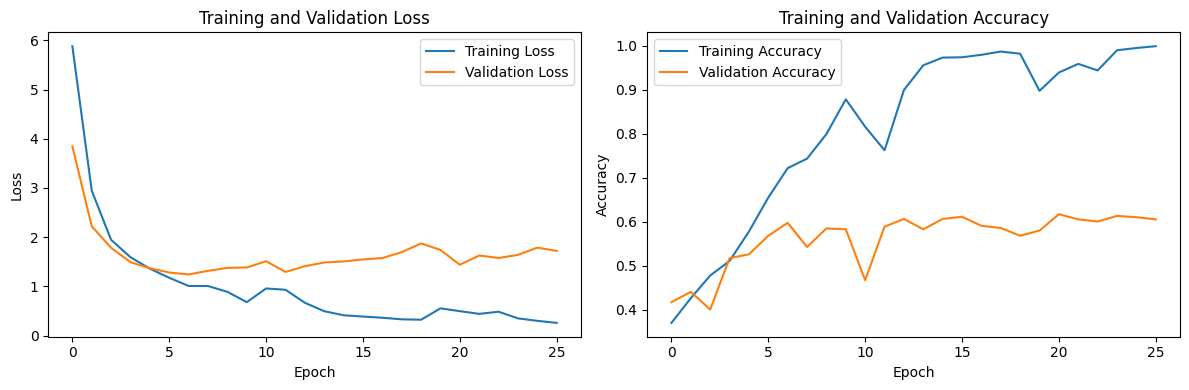

In [76]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
X_test, _, _ = preprocessing_pipeline(test_texts,
                                      MAX_VOCAB_SIZE,
                                      MAX_SEQUENCE_LENGTH,
                                      stopwords_vi=None,
                                      tokenizer=tokenizer)
y_test = encoding_labels(test_labels)

score = model.evaluate(X_test, y_test)

print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1] * 100}%")

model1 = load_model(f'{result_path}/{architecture}_{we}_checkpoint.h5')

score = model1.evaluate(X_test, y_test)

print(f"Prev Loss: {score[0]}")
print(f"Prev Accuracy: {score[1] * 100}%")

33/33 [==============================] - 2s 13ms/step - loss: 1.5964 - accuracy: 0.6095
Loss: 1.596448302268982
Accuracy: 60.952383279800415%
33/33 [==============================] - 1s 9ms/step - loss: 1.5964 - accuracy: 0.6095
Prev Loss: 1.596448302268982
Prev Accuracy: 60.952383279800415%
